<a href="https://colab.research.google.com/github/pahwa1902/Learning/blob/master/Product_Detection_Shobhit_Pahwa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import cv2
import os
import tensorflow as tf
import numpy as np
from keras.models import Model
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, LeakyReLU, ZeroPadding2D, Dense
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from keras import backend as K

Using TensorFlow backend.


In [0]:
labels = ['prod_0','prod_1','prod_2','prod_3','prod_4','prod_5','prod_6','prod_7','prod_8','prod_9','prod_10']


In [0]:
image_H,image_W = 720,720
Grid_H, Grid_W = 12,12
classes = len(labels)
anchors=1
batch_size=32
RATE=0.001
no_object_weight = 0.5
cord_weight = 3
beat_1=0.9
beta_2=0.99
threshold = 0.6

In [0]:
y=[]
for i in range(11):
  y.append(str(i))


In [0]:
y_label=np.array(y)

In [0]:
# mounting google drive to load images into colab
from google.colab import drive
drive.mount('/content/drive')

In [0]:
# number of images present of a product
def size(path,label,length):
  
  for i in label:
    length += (len(os.listdir('/content/drive/My Drive/GroceryDataset_part1/'+path+'/'+i)))
  return length

In [0]:
length = 0

In [0]:
length = size('ProductImagesFromShelves',y_label,length)


In [0]:
length = size('BrandImagesFromShelves',y_label[1:],length)

In [0]:
total_images = length

In [0]:
def box_iou(box1, box2):
    intersect_w = _interval_overlap([box1.xmin, box1.xmax], [box2.xmin, box2.xmax])
    intersect_h = _interval_overlap([box1.ymin, box1.ymax], [box2.ymin, box2.ymax])  
    
    intersect = intersect_w * intersect_h

    w1, h1 = box1.xmax-box1.xmin, box1.ymax-box1.ymin
    w2, h2 = box2.xmax-box2.xmin, box2.ymax-box2.ymin
    
    union = w1*h1 + w2*h2 - intersect
    
    return float(intersect) / union

In [0]:
list_ds = tf.data.Dataset.list_files(str('/content/drive/My Drive/GroceryDataset_part1/*/*/*'))

In [0]:
# generating labels of image corresponding to a particular product
def get_label(path):
  parts = tf.strings.split(path,os.path.sep)
  label = (parts[-2]== y_label)
  return tf.cast(label,dtype=tf.int32)

In [0]:
# transforming img to make training faster
def transform(img):
  img = tf.image.decode_png(img, channels=3)
  img = tf.image.resize(img, [image_W, image_H])
  img = tf.image.convert_image_dtype(img, tf.float32)
  img = img/255
  return img

In [0]:
# generating dataset to train
def pre_process(path):
  label = get_label(path)
  img = tf.io.read_file(path)
  img = transform(img)
  return img,label

In [0]:
labeled_ds = list_ds.map(pre_process) # transformations and data generating applied to all product images

In [0]:
# train, validation dataset split(90 and 10 percent)
train_dataset = labeled_ds.take(int(.9*total_images))
valid_dataset = labeled_ds.take(int(total_images-int(0.9*total_images)))

In [0]:
train_dataset = train_dataset.shuffle(1000).batch(batch_size)
valid_dataset = valid_dataset.batch(batch_size)

In [0]:
# get all the dimensions of object from annotations file of shelf images
with open('/content/drive/My Drive/annotations.txt') as annot:
  split_images=[]
  for line in annot:
    b = line.split(" ")
    split_images.append(b)
   

In [0]:
# decide wheather to use anchor boxes or not by looking all the aspect ratios and scale of objects

height_list=[]
width_list=[]
for i in split_images:
  image = cv2.imread('/content/drive/My Drive/ShelfImages/ShelfImages/train/'+i[0])
  c = i[2:]
  for j in range(0,len(c),5):
    
    if(image is not None):
      height_org,width_org,channel = image.shape
      width = float(c[j+2])/float(width_org)
    
      height = float(c[j+3])/float(height_org)
    
      height_list.append(height)
      width_list.append(width)

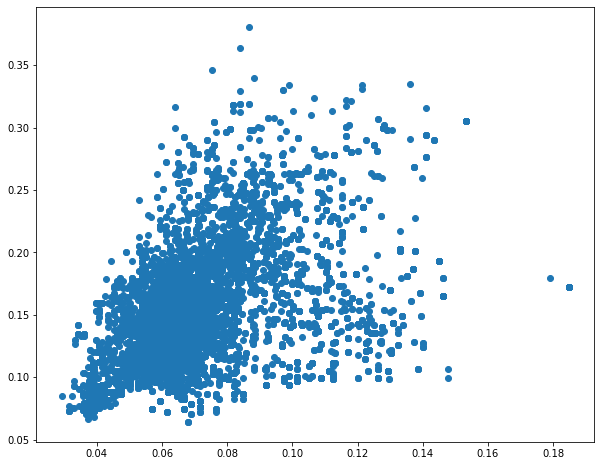

In [0]:
# graph analysis for variance of dimensions of height and width with respect to the image size
plt.figure(figsize=(10,8))
plt.scatter(width_list,height_list)

After analyzing aspect ratio and scale of all the object in all the image it has been found that aspect ratio and scale of all the objects within an image is almost similar in most of the images and therefore no anchor boxes are required as there will be no problem to training.

In [0]:
x = tuple(zip(width_list,height_list)) # preparing data for K means analysis of anchor box

In [0]:
x = np.array(x)

In [0]:
# iou of bounding box with anchor boxes
def iou(box, clusters):
    
    x = np.minimum(clusters[:, 0], box[0])
    y = np.minimum(clusters[:, 1], box[1])
    
    intersection = x * y
    box_area = box[0] * box[1]
    cluster_area = clusters[:, 0] * clusters[:, 1]

    iou_ = intersection / (box_area + cluster_area - intersection)

    return iou_

In [0]:
def avg_iou(boxes, clusters):
    
    return np.mean([np.max(iou(boxes[i], clusters)) for i in range(boxes.shape[0])])

In [0]:
# evaluating avg_iou with different numbers of anchor_boxes to get optimal value for number of anchor_boxes and there height and width
avg_iou_list = []
anchor_boxes = []
for i in range(1,10):
  nu_clusters = i
  kmeans = KMeans(n_clusters=nu_clusters)
  kmeans.fit(x)
  center = kmeans.cluster_centers_
  center = np.reshape(center,(nu_clusters,2))
  avg_iou_list.append(avg_iou(x,center))
  anchor_boxes.append(nu_clusters)


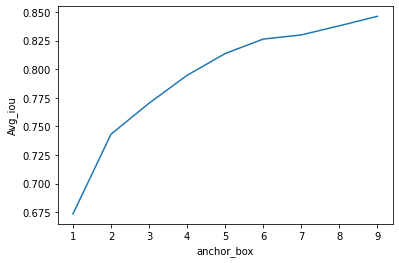

In [0]:
plt.plot(anchor_boxes,avg_iou_list) 
plt.xlabel('anchor_box')
plt.ylabel('Avg_iou')
plt.show()

In [0]:
#centers for optimal number of anchor boxes
kmean = KMeans(n_clusters=2)
kmean.fit(x)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=2, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [0]:
anchor_boxes = kmean.cluster_centers_ # I am not using anchor boxes in my calculations because of time constraints and also avg_iou increment is from 0.675 to 0.74 and can be used in the architecture


In [0]:
anchors = anchor_boxes

Increasing number of anchor box from 1 to 2 increases avg_ious score significantly

In [0]:
# rescaling images to make fast learning
def preprocess(img_list,size):
  img_data=[]
  for img in img_list:
    img = img/255
    img = cv2.resize(img,dsize=size,interpolation = cv2.INTER_AREA)
    img_data.append(img)
  return img_data

In [0]:
# list all the objects present in shelf images
def object_image(image_name):
  obj = {}
  for prod in range(len(labels)):
    for items in os.listdir(os.path.join(prod_dir,prod)):
      file_name = items.split(".")
      if(file_name[0] == image_name):
        if(obj[prod]):
          obj[prod] = [items]
        else:
          obj[prod].append(items)

In [0]:
# To get dimensions of objects in shelf images
def get_dim(item):
  prod_name = item.split("_")# splitting according to given name format of product image from shelves
  boxX = prod_name[5]
  boxY = prod_name[6]
  boxW = prod_name[7]
  boxH = prod_name[8]
  

  box = (boxX,boxY,boxW,boxH)
  return box

In [0]:
# get list of paths of shelf images
def file_list(path):
  file = []
  for item in os.listdir(path):
    file.append(item)
  return file

In [0]:
def scaled_box(w,h):
  return 0-w/2.,0-h/2.,0+w/2.,0+h/2.

In [0]:
# generating training data for object detection without including anchor boxes information
def batch_data(path):
  x_data = np.zeros(((len(path)),image_H,image_W,len(anchors),3))
  y_data = np.zeros(((len(path),Grid_H,Grid_W,len(anchors),4+1+classes))
  for i in range(len(path)):
    path_image = path[i]
      
    
      
    image = cv2.imread(GLOBAL_PATH+path_image)
    original_img_size = image.shape
    original_height, original_width,original_channel = original_img_size
    ojb = object_images(image_name)
    grid_list = []
       
    for prod,items in enumerate(obj):
      for item in items:
        obj_dim = get_dim(item)
        boxX,boxY,boxW,boxH = obj_dim
        adjX = (boxX*img_w)/original_width
        adjY = (boxY*img_h)/original_height
        adjW = (boxW*img_w)/original_width
        adjH = (boxH*img_h)/original_height
            
        centre_X = (adjX+adjW)/2.0
        centre_Y = (adjY+adjH)/2.0

        centre_X_adj = centre_X/(float(image_W)/float(Grid_W))
        centre_Y_adj = centre_Y/(float(image_H)/float(Grid_H))
          
        grid_X = np.float(centre_X_adj)
        grid_Y = np.float(centre_Y_adj)
            
            
        centre_X_grid = float(centre_X)/((grid_X+1)*float(image_W)/float(Grid_W))
        centre_Y_grid = float(centre_Y)/((grid_Y+1)*float(image_W)/float(Grid_W))

        box_W = boxW/(float(image_W))
        box_H = boxH/(float(image_H))

        box = [centre_X_grid,centre_Y_grid,box_W,box_H]
        box_origin = [0,0,box_W,box_Y]
        box_iou = [0-(box_W)/2.,0-(box_H)/2.,0+(box_W)/2.,0+(box_H)/2.]
        
        best_anchor = -1
        max_iou = -1

        for i in range(len(anchors)):
          anchor = anchors[i]
          iou_score = box_iou(scaled_box(anchor),box_iou)

          if(iou_score>max_iou):
            max_iou = iou_score
            best_anchor = i

        class_item = np.zeros((len(classes),))
        class_item[prod]=1
        y_data[idx,grid_X,grid_Y,best_anchor,0] = 1
        y_data[idx,grid_X,grid_Y,best_anchor,1:5] = box
        y_data[idx,grid_X,grid_Y,best_anchor,5:] = class_item

    x_data[i] = cv2.resize(image,(image_H,image_W))
  y_data = np.reshape(y_data,(len(path),Grid_H,Grid_W,len(anchor)*(5+classes)))
  return x_data, y_data

In [0]:
dataset, label = batch_data(file_list('/content/drive/My Drive/ShelfImages/ShelfImages/train'))

In [0]:
#splitting training and validation dataset
train_data = dataset[:,int(0.9*len(path))]
train_label = label[:,int(0.9*len(path))]
validate_data = dataset[int(0.9*len(path)):]
validate_label = label[int(0.9*len(path)):]

In [0]:
# converting output of conv network(y_output) for training
def output(y_output):
  anchors_tensor = K.reshape(K.variable(anchors), [1, 1, 1, num_anchors, 2])
  cell_x = tf.to_float(tf.reshape(tf.tile(tf.range(Grid_W), [Grid_H]), (Grid_H, Grid_W, 1, 1)))
  cell_y = tf.transpose(cell_x, (1,0,2,3))

  cell_grid = tf.tile(tf.concat([cell_x,cell_y], -1), [1, 1, 5, 1])
  pred_box_x = (tf.sigmoid(y_output[...,1]) + cell_grid)/Grid_W
  pred_box_y = (tf.sigmoid(y_output[...,2]) + cell_grid)/Grid_H
  pred_box_w = (tf.exp(y_output[...,3]*anchors_tensors)/Grid_W
  pred_box_h = (tf.exp(y_output[...,4]*anchors_tensors)/Grid_H
  confidence = tf.sigmoid(y_output[...,0])
  class_prod = tf.softmax(y_output[...,5:])

  return confidence, pred_box_x, pred_box_y, pred_box_w, pred_box_h, class_prob

In [0]:
# Yolo custom loss can be tuned according to problem requirements
def custom_loss(y_true,y_pred):
  true_X = y_true[...,1]
  true_Y = y_true[...,2]
  true_W = y_true[...,3]
  true_H = y_true[...,4]
  conf = y_true[...,0]
  prob = y_true[...,5:]

  pred_conf, box_X,box_Y,box_W,box_H, pred_prob = output(y_pred)
  lambda_object = np.zeros((Grid_H,Grid_W,1))
  lambda_no_object = np.zeros((Grid_H,Grid_W,1))
  no_object_cost = 0
  object_cost=0
  cord_cost=0
  dim_cost = 0
  class_cost = 0

  for i in range(Grid_H):
    for j in range(Grid_W):

      lambda_object[i,j,:] = 1 if conf[i,j] ==1 else 0
      lambda_no_object[i,j,:] = 1 if conf[i,j] != 1 else 0

  no_object_cost = no_object_weight*np.reduce_sum(np.multiply(lambda_no_object,np.square(conf-pred_conf)))
  object_cost = np.reduce_sum(np.multiply(lambda_object,np.square(conf-pred_conf)))
  cord_cost = np.reduce_sum(np.multiply(lambda_object,np.subtract(np.square(true_X-box_X),np.square(true_Y,box_Y))))
  dim_cost = np.reduce_sum(np.multiply(lambda_object,np.subtract(np.square(np.sqrt(true_W)-np.sqrt(box_W)),np.square(np.sqrt(true_H),np.sqrt(box_H)))))
  
  class_cost = np.reduce_sum(np.multiply(lambda_object,np.reduce_sum(np.square(prob-pred_prob))))

  total_loss = no_object_cost + object_cost + cord_cost + dim_cost

  return total_loss

In [0]:
# pre trained conv network to use for product classification
img_shape = (720,720,3)
base_model = tf.keras.applications.MobileNetV2(input_shape=img_shape,
                                               include_top=False,
                                               weights='imagenet')

In [0]:
# Making 100 layers of base model untrainable 
layers_len = len(base_model.layers)
for i in range(100,layers_len):
  base_model.layers[i].trainable = True
for j in range(100):
  base_model.layers[j].trainable = False


In [0]:
base_model.summary()

In [0]:
# adding three more layers on top of mobilenetv2 network
conv_layer_1 = tf.keras.layers.Conv2D(920,(3,3))
pool_layer= tf.keras.layers.GlobalAveragePooling2D()
output_layer = tf.keras.layers.Dense(11,activation='softmax')

In [0]:
model_class = tf.keras.Sequential([
         base_model,
         conv_layer_1,
         pool_layer,
         output_layer                    
])

In [0]:
precision = tf.keras.metrics.Precision()
recall= tf.keras.metrics.Recall()
optimizer = tf.keras.optimizers.Adam(learning_rate=RATE)

In [0]:
earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=3)

In [0]:
checkpoint_path = "training_1/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path)

In [0]:
model_class.compile(optimizer=optimizer,loss='categorical_crossentropy',metrics=['accuracy',precision,recall])

In [0]:
model_class.fit(train_dataset,epochs=20,validation_data = valid_dataset,callbacks=[earlystopping,checkpoint])

In [0]:
input_x = model_class.layers[0].layers[-36].output # taking output of pretrained layer on product images as input so that the weights of that model can be used for this training
X = Conv2D(128,(1,1),padding='valid')(input_x)
X = Conv2D(256,(3,3),padding='same')(X)
X = Conv2D(512,(1,1),padding='same')(X)
X = BatchNormalization()(X)
X = MaxPooling2D((2,2),stride=(2,2))(X)
X = LeakyReLU()(X)

X = Conv2D(128,(1,1),padding='valid')(X)
X = Conv2D(256,(3,3),padding='same')(X)
X = Conv2D(512,(1,1),padding='same')(X)
X = BatchNormalization(X)
X = MaxPooling2D((2,2),stride=(2,2))(X)
X = LeakyRelu()(X)

X = Conv2D(128,(1,1))(X)
output = Conv2D(16,(1,1))(X)

model_object = Model(input = input_x, output =  output) # creating the model for object detection by adding layers on top of pretrained model for product images

In [0]:
Earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=3) # Monitoring val_loss to end trainig before completing epochs

In [0]:
checkpath = '/training/chk-2'
checkpoints = tf.keras.callbacks.ModelCheckpoint(checkpath)

In [0]:
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate,beta_1=beta_1, beta_2=beta_2)

In [0]:
model_object.compile(optimizer = optimizer, loss=custom_loss,metrics=['precision','recall'])

In [0]:
model_object.fit([train_data,train_label],epoch=10,batch_size=batch_size,validation_data=[validation_data,validation_label],callbacks=[Earlystopping,checkpoints])

In [0]:
def filter_box(predict_y,threshold):
  conf,x,y,w,h,class_prob = output(predict_y)

  box_scores = box_confidence*box_class_probs
  
  box_classes = K.argmax(box_scores,axis=-1)
  box_class_scores = K.max(box_scores,axis=-1)

  filtering_mask = box_class_scores>threshold
  scores = tf.boolean_mask(box_class_scores,filtering_mask,name='boolean_mask_scores')
  boxes = tf.boolean_mask(boxes,filtering_mask,name='boolean_mask_box')
  classes = tf.boolean_mask(box_classes,filtering_mask,name='boolean_mask_class')

  return scores,boxes,classes

In [0]:
def predict(image):
  decode_image = cv2.imdecode(image)
  resize_image = cv2.resize(decode_image,(image_H,image_W))

  predict = model_object.predict(resize_image)
  return filter_box(predict,threshold)